# Synthetic Population Plot in California and Distance to Recycling Centers

## Initialization

In [1]:
!pip install geojson
!pip install gdown
!pip install SciencePlots
!pip install latex
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for latex: filename=latex-0.7.0-py3-none-any.whl size=7589 sha256=03839f61c057f27c00547de17c86c6e0ce5d0cad4d84f3e3a38789c19058682f
  Stored in directory: /root/.cache/pip/wheels/7e/02/25/c00dfc203e8ba53dfc2e4e97d40e537263d6e03606681f3872
  Created wheel for data: filename=data-0.4-py3-none-any.whl size=7228 sha256=84e24af1cb1b48850ef1ec79d35e714579f2c0dbde4ff7f317388d41fff5b8a1
  Stored in directory: /root/.cache/pip/wheels/d0/e8/fa/e253c256048ea58d99a8abb5e751abb6a838af6f12887b5418
  Created wheel for shutilwhich: filename=shutilwhich-1.1.0-py3-none-any.whl size=2766 sha256=2df094776d29ed219bbe3f0c95836d063af056f9b91193715890654f76577557
  Stored in directory: /root/.cache/pip/wheels/75/1f/1c/0ecab7ceabad0b8e018891505911e82a6f358a0291e7681bae
  Created wheel for tempdir: filename=tempdir-0.7.1-py3-none-any.w

In [2]:
# Import all required packages
import pandas as pd
from geopy.distance import geodesic
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scienceplots
from shapely.geometry import Point
from shapely.wkt import loads
from shapely.ops import transform
import geojson
from geojson import Feature, FeatureCollection
import pyproj
import gdown
import zipfile

## Definition of Classes

In [3]:
class County():
    def __init__(self, ID, name, population, area, geometry):
        self.ID = ID
        self.name = name
        self.population = population
        self.area = area
        self.geometry = geometry

In [4]:
proj_wgs84 = pyproj.CRS('EPSG:4326')
proj_california_albers = pyproj.CRS('EPSG:3310')
project = pyproj.Transformer.from_crs(proj_wgs84, proj_california_albers, always_xy=True).transform
class BlockGroup():
    def __init__(self, ID, countyID, population, geometry):
        self.ID = ID
        self.countyID = countyID
        self.population = population
        self.geometry = geometry
        self.area = transform(project, geometry).area*3.861e-7

In [5]:
class RecyclingCenter():
    def __init__(self, ID, address, lat, lon, countyID):
        self.ID = ID #1 to 1244
        self.address = address #full address
        self.lat = lat
        self.lon = lon
        self.countyID = countyID

## Reading input files

In [6]:
df_recycling_centers = pd.read_csv('https://www.dropbox.com/scl/fi/unnacb85bktf54fhd4x74/Beverage-Container-Recycling-Centers-in-California-RecyclersWithCoords.csv?rlkey=tq93tif5ttnkh5ndnq7x8u2t7&st=2dnjb77n&dl=1')
df_recycling_centers

,ID,recycling location name,address,city,zip,countyID,phone,full address,lat,lon
0,1,American Recycling,15292 Liberty St,San Leandro,94578,6001,(408) 515-9661,"15292 Liberty St San Leandro, CA 94578",37.707433,-122.122518
1,2,Dos Palos Recycling Co,1565 Olivina Ave,Livermore,94551,6001,(209) 518-4771,"1565 Olivina Ave Livermore, CA 94551",37.682620,-121.779073
2,3,Fry's Metals,1845 W Winton Ave,Hayward,94545,6001,(510) 276-4344,"1845 W Winton Ave Hayward, CA 94545",37.653532,-122.126860
3,4,J&D Recycling LLC,1015 N Amphlett Blvd,San Mateo,94401,6081,(650) 685-1901,"1015 N Amphlett Blvd San Mateo, CA 94401",37.585608,-122.331322
4,5,Jado Recycling,39200 Paseo Padre Pkwy,Fremont,94538,6001,(855) 857-8020,"39200 Paseo Padre Pkwy Fremont, CA 94538",37.553851,-121.978888
...,...,...,...,...,...,...,...,...,...,...
1239,1240,Richfield Metal & Recycling,1114 Yolo St,Corning,96021,6103,(530) 988-3033,"1114 Yolo St Corning, CA 96021",39.929197,-122.179971
1240,1241,S & L Recycling,7949 Hwy 99E,Los Molinos,96055,6103,(530) 567-5074,"7949 Hwy 99E Los Molinos, CA 96055",40.128463,-122.122423
1241,1242,RB Recycling,137-1/2 S State St,Earlimart,93219,6107,(559) 799-9513,"137-1/2 S State St Earlimart, CA 93219",35.884005,-119.271261
1242,1243,Camarillo Recycling Inc,849 Via Alondra,Camarillo,93012,6111,(805) 987-0226,"849 Via Alondra Camarillo, CA 93012",34.226666,-119.022989


In [7]:
df_counties = pd.read_csv('https://www.dropbox.com/scl/fi/gibukcy73s1gzf0ff9rol/Beverage-Container-Recycling-Centers-in-California-Counties.csv?rlkey=stjzmgvh3wcyx5q2mha99gfkp&st=y0tzj1qo&dl=1')
df_counties = gpd.GeoDataFrame(df_counties, crs="EPSG:4326", geometry = df_counties['geometry'].apply(loads))
df_counties

,ID,county,population,area,geometry
0,6001,Alameda,1622188,738,"POLYGON ((-122.33371 37.80980, -122.30393 37.8..."
1,6003,Alpine,1141,739,"POLYGON ((-120.07248 38.50987, -120.07239 38.7..."
2,6005,Amador,41811,606,"POLYGON ((-121.02751 38.50829, -120.81295 38.5..."
3,6007,Butte,207172,1640,"POLYGON ((-122.04487 39.88377, -121.80404 39.8..."
4,6009,Calaveras,46565,1020,"POLYGON ((-120.99550 38.22540, -120.89286 38.2..."
5,6011,Colusa,22037,1151,"POLYGON ((-122.78509 39.38298, -122.73906 39.3..."
6,6013,Contra Costa,1155025,720,"POLYGON ((-122.42526 37.95567, -122.36758 37.9..."
7,6015,Del Norte,26589,1008,"POLYGON ((-124.21959 41.84643, -124.20340 41.9..."
8,6017,El Dorado,192215,1712,"POLYGON ((-121.14159 38.71194, -121.08734 38.8..."
9,6019,Fresno,1017162,5963,"POLYGON ((-120.65595 36.95283, -120.59057 36.9..."


In [8]:
df_block_groups = pd.read_csv('https://www.dropbox.com/scl/fi/mj8d7zz8yzhcn6vzl4y4j/Beverage-Container-Recycling-Centers-in-California-Block-Groups.csv?rlkey=q50pemcibge36solw42imqxep&st=psh8imca&dl=1')
df_block_groups = gpd.GeoDataFrame(df_block_groups, crs="EPSG:4326", geometry = df_block_groups['geometry'].apply(loads))
df_block_groups

,ID,countyID,county,total,geometry
0,60290021001,6029,Kern County,422,"MULTIPOLYGON (((-119.00074 35.36158, -118.9990..."
1,60290021002,6029,Kern County,984,"MULTIPOLYGON (((-119.00093 35.35922, -119.0009..."
2,60290021003,6029,Kern County,1081,"MULTIPOLYGON (((-119.00301 35.35244, -119.0030..."
3,60290022001,6029,Kern County,1767,"MULTIPOLYGON (((-118.98870 35.36755, -118.9877..."
4,60290022002,6029,Kern County,702,"MULTIPOLYGON (((-118.98859 35.36303, -118.9885..."
...,...,...,...,...,...
23184,60590877014,6059,Orange County,479,"MULTIPOLYGON (((-117.96504 33.82093, -117.9647..."
23185,60590878063,6059,Orange County,3205,"MULTIPOLYGON (((-117.97585 33.81759, -117.9753..."
23186,60590876025,6059,Orange County,852,"MULTIPOLYGON (((-117.95015 33.80840, -117.9501..."
23187,60590879012,6059,Orange County,2125,"MULTIPOLYGON (((-117.99927 33.80282, -117.9992..."


In [9]:
water_zip_file = 'water_areas.zip'
water_zip_url = 'https://www.dropbox.com/scl/fi/5gsenwobsoyfzmmuq4oln/tl_2023_06_areawater.zip?rlkey=d3sfj9zpzoraw1rrz5zadfz98&st=1ylgcnr9&dl=1'
gdown.download(water_zip_url, water_zip_file, quiet=False)

with zipfile.ZipFile(water_zip_file, 'r') as zip_ref:
    zip_ref.extractall('')

Downloading...
From: https://www.dropbox.com/scl/fi/5gsenwobsoyfzmmuq4oln/tl_2023_06_areawater.zip?rlkey=d3sfj9zpzoraw1rrz5zadfz98&st=1ylgcnr9&dl=1
To: /content/water_areas.zip
100%|██████████| 25.6M/25.6M [00:01<00:00, 13.5MB/s]


## Creating objects

In [10]:
nodes = dict()
for i, row in df_recycling_centers.iterrows():
    nodes[row['ID']] = RecyclingCenter(row['ID'], row['full address'], row['lat'], row['lon'], row['countyID'])

In [11]:
recycling_centers = dict()
for i, row in df_recycling_centers.iterrows():
    recycling_center = RecyclingCenter(row['ID'], row['full address'], row['lat'], row['lon'], row['countyID'])
    if row['countyID'] in recycling_centers:
        recycling_centers[row['countyID']].append(recycling_center)
    else:
        recycling_centers[row['countyID']] = [recycling_center]

In [12]:
block_groups = dict()
for i, row in df_block_groups.iterrows():
    block_group = BlockGroup(row['ID'], row['countyID'], row['total'], row['geometry'])
    if row['countyID'] in block_groups:
        block_groups[row['countyID']].append(block_group)
    else:
        block_groups[row['countyID']] = [block_group]

In [13]:
counties = dict()
for i, row in df_counties.iterrows():
    population = 0
    counties[row['ID']] = County(row['ID'], row['county'],
        sum(block_group.population for block_group in block_groups[row['ID']]), row['area'], row['geometry'])

## Generating points and calculating distances

In [14]:
def generate_random_points(polygon, num_points, water):
    min_x, min_y, max_x, max_y = polygon.bounds
    points = []

    while len(points) < num_points:
        random_point = Point(np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
        if polygon.intersects(random_point) and not water.intersects(random_point).any():
            points.append(random_point)

    return points

In [23]:
def generate_random_points_per_county(countyID, path):
    water = gpd.read_file('tl_2023_06_areawater/tl_2023_' + str(countyID).zfill(5) + '_areawater.shp')

    points = []
    features = []
    for block_group in block_groups[countyID]:
        points_per_bg = generate_random_points(block_group.geometry, block_group.population, water)
        points.extend(points_per_bg)
        # Save in geojson format
        for point in points_per_bg:
            features.append(Feature(geometry=point, properties={'ID': countyID}))

    feature_collection = FeatureCollection(features)
    with open(path, 'w') as f:
        geojson.dump(feature_collection, f, indent=2)

    return points

In [16]:
def calculate_distance(origin, destination, unit = 'mi'):
  origin_coordinates = (origin.y, origin.x)
  destination_coordinates = (destination.lat, destination.lon)
  if unit == 'km':
    distance = (geodesic(origin_coordinates, destination_coordinates)).km
  elif unit == 'mi':
    distance = (geodesic(origin_coordinates, destination_coordinates)).mi
  return distance

In [17]:
def calculate_distances(countyID, points, features):
    if countyID not in recycling_centers:
        for point in points:
            feature = Feature(geometry=point, properties={
                'ID': countyID,
                'distance': -1
            })
            features.append(feature)
        return -1
    sum_distances = 0
    num_points = len(points)
    for i in range(num_points):
        # print(str(i) + '/' + str(num_points))
        min_distance = calculate_distance(points[i], recycling_centers[countyID][0])
        for j in range(1, len(recycling_centers[countyID])):
            distance = calculate_distance(points[i], recycling_centers[countyID][j])
            if distance < min_distance:
                min_distance = distance
        sum_distances += min_distance
        feature = Feature(geometry=points[i], properties={
            'ID': countyID,
            'distance': min_distance
        })
        features.append(feature)
    return sum_distances/num_points

In [18]:
population_zip_file = 'population_plots.zip'
population_zip_url = 'https://www.dropbox.com/scl/fi/1k16whz8lcppicju0kcfc/population_plots.zip?rlkey=eyp8hzumlm8upg3dw7iy184w8&st=hikv14si&dl=1'
gdown.download(population_zip_url, population_zip_file, quiet=False)

with zipfile.ZipFile(population_zip_file, 'r') as zip_ref:
    zip_ref.extractall('')

Downloading...
From: https://www.dropbox.com/scl/fi/1k16whz8lcppicju0kcfc/population_plots.zip?rlkey=eyp8hzumlm8upg3dw7iy184w8&st=hikv14si&dl=1
To: /content/population_plots.zip
100%|██████████| 10.3G/10.3G [12:40<00:00, 13.6MB/s]


In [19]:
for county in counties.values():
    file_path = "population_plots/recycling_centers_demand_" + str(county.ID).zfill(5) + ".geojson"
    try:
        f = open(file_path)
    except:
        file2_path = "population_plots/demand_points_" + str(county.ID).zfill(5) + ".geojson"
        try:
            f2 = open(file2_path)
            existing_data = geojson.load(f2)
            points_features = existing_data['features']
            points = []
            for feature in points_features:
                points.append(Point(feature['geometry']['coordinates'][0], feature['geometry']['coordinates'][1]))
        except:
            points = generate_random_points_per_county(county.ID, file2_path)

        features = []
        distance = calculate_distances(county.ID, points, features)

        feature_collection = FeatureCollection(features)
        with open(file_path, 'w') as f:
            geojson.dump(feature_collection, f, indent=2)

        print(county.name, distance)
    else:
        print(f"File for county with ID {county.ID} already exists and will not be computed again.")

File for county with ID 6001 already exists and will not be computed again.
File for county with ID 6003 already exists and will not be computed again.
File for county with ID 6005 already exists and will not be computed again.
File for county with ID 6007 already exists and will not be computed again.
File for county with ID 6009 already exists and will not be computed again.
File for county with ID 6011 already exists and will not be computed again.
File for county with ID 6013 already exists and will not be computed again.
File for county with ID 6015 already exists and will not be computed again.
File for county with ID 6017 already exists and will not be computed again.
File for county with ID 6019 already exists and will not be computed again.
File for county with ID 6021 already exists and will not be computed again.
File for county with ID 6023 already exists and will not be computed again.
File for county with ID 6025 already exists and will not be computed again.
File for cou

The subset of recycling centers considered for the average distance followed a priority list. If one type of data was not available for a given county, the scope was broadened as follows:


1.   The recycling centers located inside the county;
2.   The recycling centers present in the county list as for https://www2.calrecycle.ca.gov/BevContainer/RecyclingCenters/ (accessed on May 28);
3.   The recycling centers present in the lists of the adjacent counties as for https://www2.calrecycle.ca.gov/BevContainer/RecyclingCenters/ (accessed on May 28).



In [24]:
def generate_random_points_per_county(countyID):
    water = gpd.read_file('tl_2023_06_areawater/tl_2023_' + str(countyID).zfill(5) + '_areawater.shp')
    points = []
    for block_group in block_groups[countyID]:
        points.extend(generate_random_points(block_group.geometry, block_group.population, water))
    return points

def calculate_distances(countyID, points, features, recycling_centers_ids, recycling_center_counties_ids):
    reachable_recycling_centers = []
    for id in recycling_center_counties_ids:
        for recycling_center in recycling_centers[id]:
            if recycling_center.ID in recycling_centers_ids:
                reachable_recycling_centers.append(recycling_center)

    sum_distances = 0
    num_points = len(points)
    for i in range(num_points):
        # print(str(i) + '/' + str(num_points))
        min_distance = calculate_distance(points[i], reachable_recycling_centers[0])
        for j in range(1, len(reachable_recycling_centers)):
            distance = calculate_distance(points[i], reachable_recycling_centers[j])
            if distance < min_distance:
                min_distance = distance
        sum_distances += min_distance
        feature = Feature(geometry=points[i], properties={
            'ID': countyID,
            'distance': min_distance
        })
        features.append(feature)
    return sum_distances/num_points

# Example for Trinity
county = counties[6105]

file_path = "population_plots/recycling_centers_demand_" + str(county.ID).zfill(5) + ".geojson"
points = generate_random_points_per_county(county.ID)

features = []
recycling_centers_ids = {195, 196, 197, 198, 276, 277, 278, 779, 780, 781, 782, 783, 784, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1238, 1239, 1240, 1241} # manually listed
recycling_center_counties_ids = [6023, 6033, 6045, 6089, 6093, 6103]
distance = calculate_distances(county.ID, points, features, recycling_centers_ids, recycling_center_counties_ids)

feature_collection = FeatureCollection(features)
with open(file_path, 'w') as f:
    geojson.dump(feature_collection, f, indent=2)

print(county.name, distance)

Trinity 28.417103448605676


In [ ]:
distances_per_county = dict()

for county in counties.values():
    file_path = "population_plots/recycling_centers_demand_" + str(county.ID).zfill(5) + ".geojson"
    try:
        f = open(file_path)
        existing_data = geojson.load(f)
        features = existing_data['features']

        distances_per_county[county.ID] = 0
        for feature in features:
            distances_per_county[county.ID] += feature['properties']['distance']
        distances_per_county[county.ID] /= county.population
    except:
        print(f"No available data for county with ID {county.ID}.")

distances_per_county

In [20]:
distances_per_county = {
    6001: 2.261298239127406,
    6003: 19.04777731845084,
    6005: 5.060395125262591,
    6007: 8.353097062323139,
    6009: 8.259864063055977,
    6011: 8.865146748174947,
    6013: 4.776637067588885,
    6015: 5.555024405893619,
    6017: 4.045789237725721,
    6019: 2.3155708273516074,
    6021: 3.776190447262361,
    6023: 6.354824097536441,
    6025: 7.419870159705989,
    6027: 18.714253706520434,
    6029: 2.0182097112955777,
    6031: 1.9110730811114052,
    6033: 11.421874166476318,
    6035: 29.08930812573034,
    6037: 1.2926745354223437,
    6039: 2.9104093977259886,
    6041: 9.461561922958184,
    6043: 12.26666205197484,
    6045: 6.547871307890972,
    6047: 1.8800910250523915,
    6049: 17.816359904706978,
    6051: 16.241113589948284,
    6053: 2.9844593389795544,
    6055: 2.5585814908203717,
    6057: 13.845370834739223,
    6059: 1.4542853714534234,
    6061: 2.841142402213943,
    6063: 14.180757820932559,
    6065: 2.197497047112441,
    6067: 1.7955626555003046,
    6069: 3.0905868797438956,
    6071: 2.2136224464248566,
    6073: 2.3521629349385442,
    6075: 0.6088189293773659,
    6077: 2.2359850643017642,
    6079: 6.829757496369016,
    6081: 2.349656810366779,
    6083: 2.5196059936800568,
    6085: 1.9006570601008568,
    6087: 5.794055777094178,
    6089: 5.095649514566903,
    6091: 22.37171508024337,
    6093: 13.683634099467707,
    6095: 3.060850245575909,
    6097: 3.59359710263501,
    6099: 1.5027888031694867,
    6101: 2.1161068392369375,
    6103: 6.7619845852640665,
    6105: 28.460647199646402,
    6107: 1.9964433504993429,
    6109: 6.2558302749524595,
    6111: 1.6672262485792442,
    6113: 2.349540539869948,
    6115: 5.335224243635559
}

## Visualizing plots and distances

In [21]:
df_counties['distance'] = df_counties['ID'].map(distances_per_county)

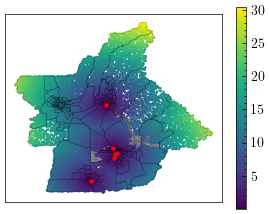

In [27]:
plt.style.use('science')
# for county in counties.values():
county = counties[6007]
gdf_county = gpd.GeoSeries([county.geometry])
ax = gdf_county.plot(edgecolor='none', facecolor='none')
gdf_population = gpd.read_file("population_plots/recycling_centers_demand_" + str(county.ID).zfill(5) + ".geojson")
gdf_population.plot(ax=ax, column='distance', legend=True, markersize=0.5, vmin=0.009543743862353913, vmax=30.434794864397755)
gdf_water_area = gpd.read_file("tl_2023_06_areawater/tl_2023_" + str(county.ID).zfill(5) + "_areawater.shp")
gdf_water_area.plot(ax=ax, edgecolor='none', facecolor='gray')
for block_group in block_groups[county.ID]:
    gdf_block_group = gpd.GeoSeries([block_group.geometry])
    gdf_block_group.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=0.1)
if county.ID in recycling_centers:
    gpf_recycling_centers = gpd.GeoSeries([Point(recycling_center.lon, recycling_center.lat) for recycling_center in recycling_centers[county.ID]])
    gpf_recycling_centers.plot(ax=ax, color='r', markersize=5)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.savefig(county.name + ".png", dpi=300)

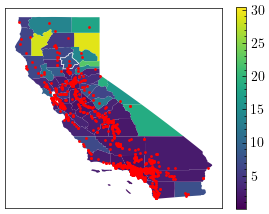

In [26]:
plt.style.use('science')
ax = df_counties.plot(column='distance', legend=True, vmin=0.009543743862353913, vmax=30.434794864397755)
gpd.GeoSeries(counties[6007].geometry).plot(ax=ax, edgecolor='w', facecolor='none', linewidth=0.5)
recycling_centers_points = []
for county in counties.values():
    if county.ID in recycling_centers:
        for recycling_center in recycling_centers[county.ID]:
            recycling_centers_points.append(Point(recycling_center.lon, recycling_center.lat))
recycling_centers_plot = gpd.GeoSeries(recycling_centers_points)
recycling_centers_plot.plot(ax=ax, color='red', markersize=1)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.savefig("California.png", dpi=300)